[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!

Total sentiments in train set:
Sentiment
positive    560
negative     72
neutral      67
Name: count, dtype: int64

Total sentiments in test set:
Sentiment
positive    221
neutral      41
negative     38
Name: count, dtype: int64
Time to build vocab: 0.0 mins
Time to train the model: 0.02 mins
Epoch 1/10
----------
Epoch 1/10, Loss: 0.6195926458828829, Accuracy: 0.7868383404864091
Epoch 2/10
----------
Epoch 2/10, Loss: 0.49570954512720083, Accuracy: 0.8197424892703863
Epoch 3/10
----------
Epoch 3/10, Loss: 0.38970596401486546, Accuracy: 0.8669527896995708
Epoch 4/10
----------
Epoch 4/10, Loss: 0.30722547361140395, Accuracy: 0.8927038626609443
Epoch 5/10
----------
Epoch 5/10, Loss: 0.32601442726709967, Accuracy: 0.9113018597997139
Epoch 6/10
----------
Epoch 6/10, Loss: 0.20746970496309752, Accuracy: 0.9356223175965666
Epoch 7/10
----------
Epoch 7/10, Loss: 0.1208717

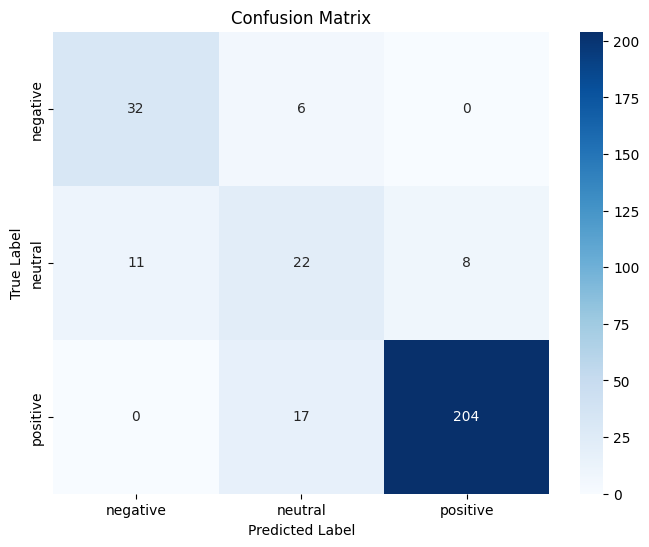

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from gensim.models import Word2Vec
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
from time import time

# Load dataset
data_path = '/kaggle/input/tripadvisor-1000-dataset-examples/trip-advisor-copy.csv'
data = pd.read_csv(data_path)

# Preprocessing: Text Cleaning, Tokenization, and Normalization
nltk.download('punkt')

def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

data['Cleaned_Review'] = data['Review'].apply(clean_text)

# Adjust labels for sentiment analysis
data['Sentiment'] = pd.cut(data['Rating'], bins=[-np.inf, 2, 3, np.inf], labels=['negative', 'neutral', 'positive'], right=False)

# Split data into train and test sets (70% train, 30% test)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['Cleaned_Review'], data['Sentiment'], test_size=0.3, random_state=42)

# Print total sentiment in train and test set
print("\nTotal sentiments in train set:")
print(train_labels.value_counts())

print("\nTotal sentiments in test set:")
print(test_labels.value_counts())

# Tokenize the text for Word2Vec
sentences = [nltk.word_tokenize(text) for text in data['Cleaned_Review']]

# Train Word2Vec model
cores = multiprocessing.cpu_count()
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)

t = time()
w2v_model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

t = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

# Convert text data to Word2Vec vectors (average of word vectors)
def text_to_vector(text):
    tokens = nltk.word_tokenize(text.lower())
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(300)

train_vectors = np.array([text_to_vector(text) for text in train_texts])
test_vectors = np.array([text_to_vector(text) for text in test_texts])

class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.linear = nn.Linear(300, 768)
        self.dropout = nn.Dropout(p=0.3)
        self.classifier = nn.Linear(768 * 2, n_classes)  # Combine BERT and Word2Vec embeddings

    def forward(self, input_ids, attention_mask, word2vec_embeddings):
        # BERT
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_outputs.pooler_output

        # Word2Vec
        word2vec_embeddings = self.linear(word2vec_embeddings)
        word2vec_embeddings = self.dropout(word2vec_embeddings)

        # Combine BERT and Word2Vec embeddings
        combined = torch.cat((pooled_output, word2vec_embeddings), dim=1)
        output = self.classifier(combined)
        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentClassifier(len(data['Sentiment'].unique()))
model = model.to(device)

class ReviewDataset(Dataset):
    def __init__(self, reviews, ratings):
        self.reviews = reviews
        self.ratings = ratings
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews.iloc[idx]
        rating = self.ratings.iloc[idx]
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=512,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        word2vec_vector = torch.tensor(text_to_vector(review), dtype=torch.float)

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'word2vec_embeddings': word2vec_vector,
            'labels': torch.tensor(0 if rating == 'negative' else 1 if rating == 'neutral' else 2, dtype=torch.long)  # Adjusted labels
        }

def create_data_loader(reviews, ratings, batch_size):
    ds = ReviewDataset(reviews, ratings)
    return DataLoader(ds, batch_size=batch_size, num_workers=2)

BATCH_SIZE = 8
train_data_loader = create_data_loader(train_texts, train_labels, BATCH_SIZE)
test_data_loader = create_data_loader(test_texts, test_labels, BATCH_SIZE)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss().to(device)

# Training loop
EPOCHS = 10

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        word2vec_embeddings = d["word2vec_embeddings"].to(device)
        labels = d["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, word2vec_embeddings=word2vec_embeddings)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

# Main training loop with epoch print statements
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        None,
        len(train_texts)
    )

    print(f'Epoch {epoch + 1}/{EPOCHS}, Loss: {train_loss}, Accuracy: {train_acc}')

def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            word2vec_embeddings = d["word2vec_embeddings"].to(device)
            labels = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, word2vec_embeddings=word2vec_embeddings)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            real_values.extend(labels)

    return torch.stack(predictions).cpu(), torch.stack(real_values).cpu()

y_pred, y_true = get_predictions(model, test_data_loader)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive'])
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Confusion Matrix Visualization
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(conf_matrix, ['negative', 'neutral', 'positive'])